In [3]:
# 1b)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


N = 4.6*10**6

R = np.arange(1,1000)


# setup equations

fc1 = 1/(1+R/N*np.e**(6.439E-20/4.11E-21))
fc2 = 1/(1+R/N*np.e**(5.819E-20/4.11E-21))
fc3 = 1/(1+R/N*np.e**(4.06E-20/4.11E-21))

# plot curves
plt.plot(R,fc1,label='O1')
plt.plot(R,fc2,label='O2')
plt.plot(R,fc3,label='O3')


# plot points
plt.plot(260, 2.77E-3, marker='o', markersize=3, color="magenta", label='O1')
plt.plot(260, 1.24E-2, marker='o', markersize=3, color="magenta", label='O2')
plt.plot(260, 4.77E-1, marker='o', markersize=3, color="magenta", label='O3')

# graph details
plt.xlabel('R')
plt.ylabel('Fold Change')
plt.title('Fold Change Vs. R')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import skimage.io
import skimage.exposure
import skimage.measure

%matplotlib inline

im = skimage.io.imread('data/O1_auto_phase_pos_00.tif')

In [5]:
# function to normalize intesity
def normalize_im(im):
    im_norm = (im - im.min()) / (im.max() - im.min())
    return im_norm

In [6]:
def segment_im(im_phase, ip_dist=0.160, area_bounds=(1,4), phase_thresh=0.3, show_mask=False):
    
    phase_norm = normalize_im(im_phase)
    thresh_val = phase_thresh
    thresh_im = phase_norm < thresh_val    
    image, num_obj = skimage.measure.label(thresh_im, return_num=True)
        
    
    areas = np.zeros(num_obj)
    # calc areas
    for i in range(num_obj):
        cell = (image == i + 1)
    
        areas[i] = np.sum(cell) * ip_dist**2
        
        
    approved = np.zeros_like(thresh_im)
    
    # filter for approved cells
    for i in range(num_obj):
        cell = (image == i + 1)

        area = np.sum(cell) * ip_dist**2

        if (area > area_bounds[0]) & (area < area_bounds[1]):
            approved += cell
        
    

    approved_image, num_obj = skimage.measure.label(approved, return_num=True)

    
    
    phase_cp = np.copy(phase_norm)
    
    bar_length = int(10 / ip_dist)
    
    phase_norm[10:20, 10:10 + bar_length] = 1.0
    phase_cp[10:20, 10:10 + bar_length] = 1.0
    
    # illuminate the approved cells
    phase_cp[approved] = 1.0
    
    mask_rgb = np.dstack((phase_norm, phase_cp, phase_cp))
    
    # plot is needed
    if show_mask:
        plt.imshow(mask_rgb)
    
    
    return mask_rgb, approved

In [7]:
phase_im1 = skimage.io.imread('data/O1_delta_phase_pos_01.tif')
phase_im2 = skimage.io.imread('data/O2_delta_phase_pos_01.tif')
phase_im3 = skimage.io.imread('data/O3_auto_phase_pos_01.tif')
phase_im4 = skimage.io.imread('data/O1_R60_phase_pos_01.tif')
    

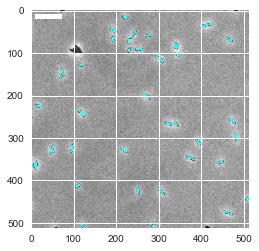

In [8]:
segment_im(phase_im1, ip_dist=0.160, phase_thresh=0.3, show_mask=True);

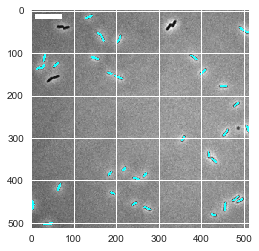

In [9]:
segment_im(phase_im2, ip_dist=0.160, phase_thresh=0.3, show_mask=True);

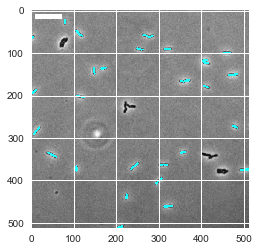

In [10]:
segment_im(phase_im3, ip_dist=0.160, phase_thresh=0.3, show_mask=True);

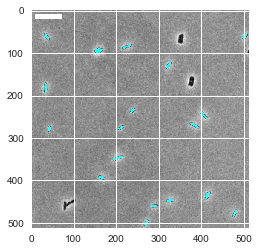

In [11]:
segment_im(phase_im4, ip_dist=0.160, phase_thresh=0.3, show_mask=True);

In [12]:
#2b
def extract_intensities(im_phase, im_fluor, ip_dist=0.160, plt_hist=False):
    
    rgb, approved = segment_im(im_phase, ip_dist=0.160)
    
    approved_image, num_obj = skimage.measure.label(approved, return_num=True)
    
    
    tot_ints = np.zeros(num_obj) 
    cell_areas = np.zeros(num_obj)
    
    # sum intensities
    for i in range(num_obj):
        cell = (approved_image == i + 1)

        cell_areas[i] = np.sum(cell) * ip_dist**2

        int_im = cell * im_fluor

        tot_ints[i] = np.sum(int_im)
        
        
    if plt_hist:
        plt.hist(tot_ints, bins=10)
        plt.xlabel('total intensity (a.u.)')
        plt.ylabel('count')
        
    return tot_ints
    
    

In [13]:
yfp_im1 = skimage.io.imread('data/O1_delta_yfp_pos_01.tif')
yfp_im2 = skimage.io.imread('data/O2_delta_yfp_pos_01.tif')
yfp_im3 = skimage.io.imread('data/O3_auto_yfp_pos_01.tif')
yfp_im4 = skimage.io.imread('data/O1_R60_yfp_pos_01.tif')

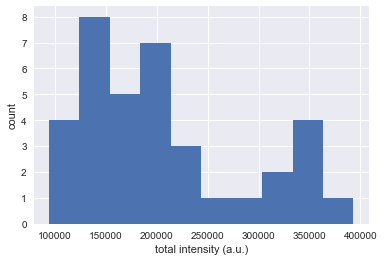

In [14]:
extract_intensities(phase_im1, yfp_im1,plt_hist=True);

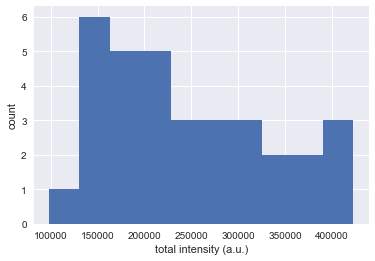

In [15]:
extract_intensities(phase_im2, yfp_im2,plt_hist=True);

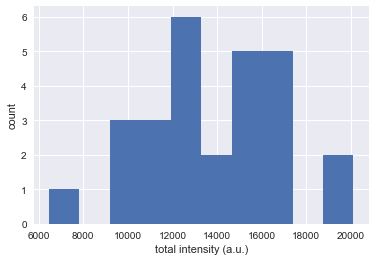

In [16]:
extract_intensities(phase_im3, yfp_im3,plt_hist=True);

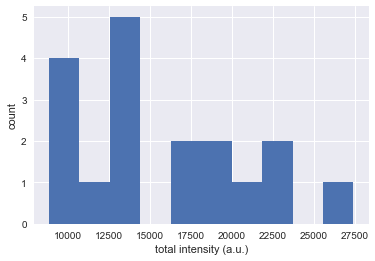

In [17]:
extract_intensities(phase_im4, yfp_im4,plt_hist=True);

In [18]:
#2c
import glob
def strain_totals(op, rep, graph_hist = False):
    
    # get paths and import
    path = 'data/'+ op + '_' + rep + '_' + 'phase*.tif'
    path_f = 'data/'+ op + '_' + rep + '_' + 'yfp*.tif'
    files = glob.glob(path), glob.glob(path_f)
    
    
    ints = []
    # read files
    for i in range(len(files[0])):
        phase_im = skimage.io.imread(files[0][i])
        fl_im = skimage.io.imread(files[1][i])


        
        intensities = extract_intensities(phase_im, fl_im)
        for i in intensities:
            ints.append(i)
            
    if graph_hist:
        plt.hist(ints, bins=10)
        plt.xlabel('total intensity (a.u.)')
        plt.ylabel('count')
        
    return ints

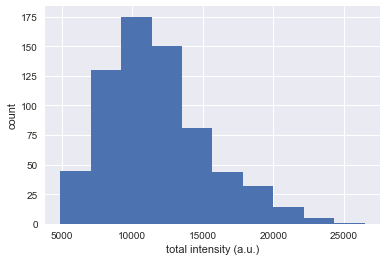

In [19]:
strain_totals('O1', 'auto',graph_hist=True);

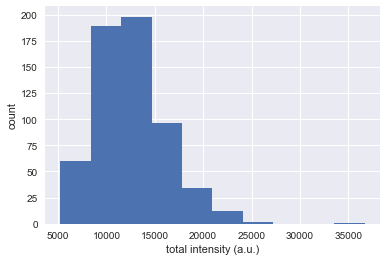

In [20]:
strain_totals('O2', 'auto',graph_hist=True);

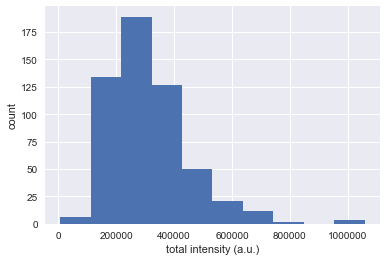

In [21]:
strain_totals('O2', 'delta',graph_hist=True);

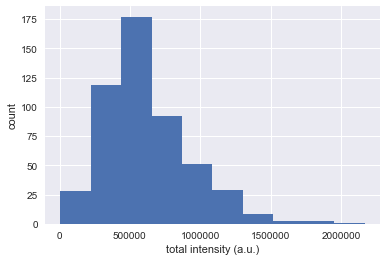

In [22]:
strain_totals('O3', 'delta',graph_hist=True);

In [23]:
#2d
ops = ['O1', 'O2', 'O3']
rep_names = ['R22', 'R60', 'R124', 'R260']
rep_nums = [22, 60, 124, 260]

fcs = []
for op in ops:
    i_delta = np.mean(strain_totals(op, 'delta'))

    i_auto = np.mean(strain_totals(op, 'auto'))
    fcs_per_rep = []
    for rep in rep_names:
        rep_mean_int = np.mean(strain_totals(op, rep))
        fc = (rep_mean_int-i_auto)/(i_delta-i_auto)
        fcs_per_rep.append(fc)
    fcs.append(fcs_per_rep)

print(fcs)
        

[[0.021024200344214549, 0.019090847506677954, 0.0097609039479722992, 0.0055768620612222644], [0.14532349300531136, 0.042168737404817386, 0.014868497501476599, 0.0097313655546251484], [0.89913028069521406, 0.74661112540743835, 0.9693887451176495, 0.7367561773749588]]


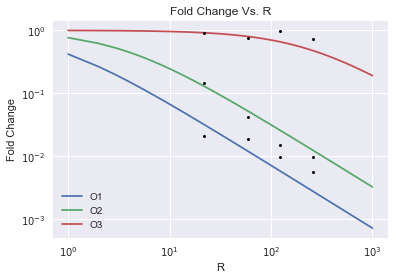

In [24]:
#2e


N = 4.6*10**6

R = np.arange(1,1000)

fc1 = 1/(1+R/N*np.e**(6.439E-20/4.11E-21))
fc2 = 1/(1+R/N*np.e**(5.819E-20/4.11E-21))
fc3 = 1/(1+R/N*np.e**(4.06E-20/4.11E-21))
plt.plot(R,fc1,label='O1')
plt.plot(R,fc2,label='O2')
plt.plot(R,fc3,label='O3')

plt.xlabel('R')
plt.ylabel('Fold Change')
plt.title('Fold Change Vs. R')
plt.xscale('log')
plt.yscale('log')


plt.legend()


for i in range(3):
    for j in range(4):
        plt.plot(rep_nums[j], fcs[i][j], marker='o', markersize=3, color="black")

Outliers may come from inconsistencies in background lighting during the experiment. We also have the possibility of cells dying during the experiment. There may have also been a poor filter. All of these effects could skew the data

3a)

We know that if we have multiple determinations that if they agree we likely have a good understanding of the underlying biological/physical phenomena because we have various angles by which to consider that all agree with oneanother indicating that they are robust. The opposite is true if various determinations lead to disagreement we know that there must be a flaw or a set of flaws in one or more approach making it a less robust understanding.



In [35]:
#3b

import scipy.optimize

import pandas as pd

kBT = 4.11E-21

data = pd.read_csv('lacZ_titration_data.csv', comment='#')

O1 = data[data['operator'] == 'O1']
O2 = data[data['operator'] == 'O2']
O3 = data[data['operator'] == 'O3']

def calc_fc(R,E):
    fc = np.log(1 / (1 + (R/N)*np.e**(-E/kBT)))
    return fc

def chi_2(fc, R, E):
    return np.sum((np.log(fc) - calc_fc(R,E))**2)
# function to plot
E_r = np.linspace(-8E-20,-1E-20)
def plt_r_sum_sqr(O, col, lab):
    


    sum_sq = np.zeros_like(E_r)

    for i in range(len(E_r)):
        sum_sq[i] = chi_2(O['fold_change'],  O['repressor'], E_r[i])
        
    min_sum_sq = np.min(sum_sq)
    
    ind = np.where(sum_sq == min_sum_sq)
    
    min_e = E_r[ind][0] * 1E20
    print('by-eye:' + str(min_e) + 'E20')
    
    plt.plot(E_r, sum_sq, color = col, label=lab)
    plt.xlabel('$\Delta\epsilon$ $(J)$')
    plt.ylabel('$\chi^2$')
    plt.title('$\chi^2$ vs $\Delta E$')
    plt.legend()
    
    return min_e
    
        
        


by-eye:-6.42857142857E20
by-eye:-5.85714285714E20
by-eye:-4.14285714286E20


-4.1428571428571423

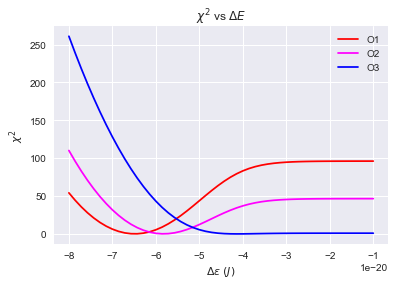

In [36]:
# plot
plt_r_sum_sqr(O1, 'red', 'O1')
plt_r_sum_sqr(O2, 'magenta', 'O2')
plt_r_sum_sqr(O3,'blue', 'O3')

best by eye: -6.14285714286E20
best by eye: -5.71428571429E20
best by eye: -3.71428571429E20


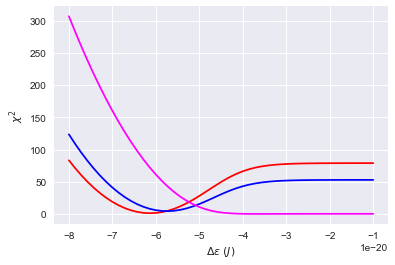

In [37]:
# 3c

# make copy with log values
log_fcs = np.copy(fcs)

for fc in log_fcs:
    fc = np.log(log_fcs)

Os = [O1, O2, O3]
colors = ['red', 'blue', 'magenta']

for O in range(len(fcs)):
    sum_sq = np.zeros_like(E_r)
    for i in range(len(E_r)):
        for j in range(3):
            sum_sq[i] = chi_2(log_fcs[O], rep_nums[j], E_r[i])
            
    min_sum_sq = np.min(sum_sq)
    
    ind = np.where(sum_sq == min_sum_sq)
    
    min_e = E_r[ind][0] * 1E20
    
    print("best by eye: " + str(min_e) + 'E20')
    
    plt.plot(E_r, sum_sq, color=colors[O])
    plt.xlabel('$\Delta\epsilon$ $(J)$')
    plt.ylabel('$\chi^2$')

The values for E are fairly different from 3b indicating an experimental setup issue for this microscopy. 

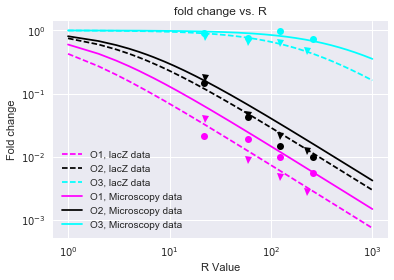

In [42]:
# Es from 3b
E = -6.4286E-20
y1 = 1 / (1 + (R/N) * np.e ** (-E/kBT))
# O2
E = -5.8571E-20
y2 = 1 / (1 + (R/N) * np.e ** (-E/kBT))
# O3
E = -4.1429E-20
y3 = 1 / (1 + (R/N) * np.e ** (-E/kBT))

plt.xlabel('R Value')
plt.ylabel('Fold change')
plt.title('fold change vs. R')
plt.plot(R,y1, label='O1, lacZ data', color='magenta', linestyle='--')
plt.plot(R,y2, label='O2, lacZ data', color='black', linestyle='--')
plt.plot(R,y3, label='O3, lacZ data', color='cyan', linestyle='--')

plt.xscale('log')
plt.yscale('log')

# Es from 3c

# O1
E = -6.1429E-20
y1 = 1 / (1 + (R/N) * np.e ** (-E/kBT))
# O2
E = -5.7143E-20
y2 = 1 / (1 + (R/N) * np.e ** (-E/kBT))
# O3
E = -3.7143E-20
y3 = 1 / (1 + (R/N) * np.e ** (-E/kBT))

plt.xlabel('R Value')
plt.ylabel('Fold change')
plt.title('fold change vs. R')
plt.plot(R,y1, label='O1, Microscopy data', color='magenta')
plt.plot(R,y2, label='O2, Microscopy data', color='black')
plt.plot(R,y3, label='O3, Microscopy data', color='cyan')


#O1 lacZ data

plt.plot(22.4, .03890, marker='v', color='magenta')
plt.plot(59.3, .00890, marker='v', color='magenta')
plt.plot(124.0, .00472, marker='v', color='magenta')
plt.plot(225, .00277, marker='v', color='magenta')

#O2 lacZ data

plt.plot(22.4, .1760, marker='v', color='black')
plt.plot(59.3, .0452, marker='v', color='black')
plt.plot(124.0, .0215, marker='v', color='black')
plt.plot(225, .0124, marker='v', color='black')

#O3 lacZ data
plt.plot(22.4, .799, marker='v', color='cyan')
plt.plot(59.3, .652, marker='v', color='cyan')
plt.plot(124.0, .621, marker='v', color='cyan')
plt.plot(225, .477, marker='v', color='cyan')


colors = ['magenta', 'black', 'cyan']
for O in range(len(Os)):
    for i in range(4):
        plt.plot(rep_nums[i], fcs[O][i], marker='o', color=colors[O])

plt.legend()

triangle points are lacZ points and circles are microscopy points

The data from the two methods seem to agree fairly well. We know that deviations could be the result of errors both systematic and random, in the expiremental method as discussed in previous sections. Additionally, we know that computer algorithms are not infallable and it is possible that a cell or cells was not properly recognized by the computer.